# Deniose Cost Function Experiments
## Derived from Train_Phase2.ipynb
## Refactored code to allow experiments on cost functions

#### 25/03/2020


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from skimage.restoration import estimate_sigma
from tensorflow.image import psnr, ssim
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_probability as tfp
import os

/home/anthonyk/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/anthonyk/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/anthonyk/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/anthonyk/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
#print("GPU Available: {}".format(tf.test.is_gpu_available()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.0.0-beta1
Eager execution: True
Num GPUs Available:  8


## Data Pipeline Functions

In [3]:
def file_dataset(source):
    '''Builds list datsets for parsing'''
    if source=='DND':
        list_ds = tf.data.Dataset.list_files('./DND/images_srgb_png/*.png')
        train_list_ds = list_ds.take(30)       # List of Training Images
        val_list_ds = list_ds.take(10)         # List of Validation Images
        test_list_ds = list_ds.take(10)        # List of Test Images
    elif source=='S7-jpg':
        list_ds = tf.data.Dataset.list_files('./S7-ISP-Dataset/*/*short*.jpg')
        train_list_ds = list_ds.take(70)      # List of Training Images
        val_list_ds = list_ds.take(20)        # List of Validation Images
        test_list_ds = list_ds.take(20)       # List of Test Images
    elif source=='S7-raw':
        list_ds = tf.data.Dataset.list_files('./S7-ISP-Dataset/*/*short*.png')
        train_list_ds = list_ds.take(70)      # List of Training Images
        val_list_ds = list_ds.take(20)        # List of Validation Images
        test_list_ds = list_ds.take(20)       # List of Test Images
    else:
        raise ValueError("Source unknown")
        
    # How many files?
    image_count = len([i for i in list_ds])
    image_count_train = len([i for i in train_list_ds])
    image_count_val = len([i for i in val_list_ds])
    image_count_test = len([i for i in test_list_ds])
    print(f'Total val Images :{image_count}')
    print(f'Training Images :{image_count_train}')
    print(f'Validation Images :{image_count_val}')
    print(f'Test Images :{image_count_test}')

    return train_list_ds, val_list_ds, test_list_ds

In [4]:
def parse_fn(filename):
    '''Takes "short" image filepath dataset.
    Returns processed "short" and "medium" image pairs (e.g. S7).
    Both images the same for other file paths e.g. DND'''
    
    image1 = read_decode(filename)   # Read 'short' image
    filename = tf.strings.regex_replace(filename, 'short','medium')
    image2 = read_decode(filename)   # Read 'medium' image

    return image1, image2

def read_decode(filename):
    '''Read Image Files and convert to image Tensors (0,1)'''
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

In [5]:
def get_rnd_patches(image1, image2, num_patches=100, patch_sz=64):
    '''Get Random Patches from image1 and corresponding patches from image2.
    image1 will be Training, image2 will be GT.
    Both images have the same dimensions'''
    patches1 = []
    patches2 = []
    for i in range(num_patches):
        image_height = 3024# image1.shape[0]
        image_width = 4032 # image1.shape[1]
        image_height = 2500# image1.shape[0]
        image_width = 2500 # image1.shape[1]

        top_left_x = tf.random.uniform([1], maxval=image_width-patch_sz, dtype=tf.int32)
        top_left_y = tf.random.uniform([1], maxval=image_height-patch_sz, dtype=tf.int32)
        patch1 = tf.image.crop_to_bounding_box(image1, top_left_y[0], top_left_x[0], patch_sz, patch_sz)
        patch2 = tf.image.crop_to_bounding_box(image2, top_left_y[0], top_left_x[0], patch_sz, patch_sz)
        
        noise = tf.random.normal(shape=tf.shape(patch1), mean=0.0, stddev=noise_std, dtype=tf.float32)
        
        #patch1 = patch1 - tf.reduce_mean(patch1, axis=[-2, -3], keepdims=True)    # zero mean Tr
        patch2 = patch2 - tf.reduce_mean(patch2, axis=[-2, -3], keepdims=True)    # zero mean GT
        patch1 = patch2 + noise     # Add noise to the 'Ground Truth' dataset to train on
    
        patches1.append(patch1)
        patches2.append(patch2)

    patches1 = tf.stack(patches1)    # patches from image1
    patches2 = tf.stack(patches2)    # patches from image2

    return patches1, patches2   # Noisy Tr, Clean GT

def get_patches(image1, image2, top_left_x, top_left_y, num_patches=100, patch_sz=64):
    '''Get Specified Patches from image1 and corresponding patches from image2.
    image1 will be Training, image2 will be GT.
    Both images have the same dimensions'''
    patches1 = []
    patches2 = []
    for i in range(num_patches):
        image_height = 3024# image1.shape[0]
        image_width = 4032 # image1.shape[1]
        image_height = 2500# image1.shape[0]
        image_width = 2500 # image1.shape[1]
        
        top_left_x = (top_left_x + patch_sz) % (image_width - patch_sz)

        patch1 = tf.image.crop_to_bounding_box(image1, top_left_y, top_left_x, patch_sz, patch_sz)
        patch2 = tf.image.crop_to_bounding_box(image2, top_left_y, top_left_x, patch_sz, patch_sz)
        
        noise = tf.random.normal(shape=tf.shape(patch1), mean=0.0, stddev=noise_std, dtype=tf.float32)
        
        #patch1 = patch1 - tf.reduce_mean(patch1, axis=[-2, -3], keepdims=True)    # zero mean
        patch2 = patch2 - tf.reduce_mean(patch2, axis=[-2, -3], keepdims=True)    # zero mean
        patch1 = patch2 + noise     # Add noise to the 'Ground Truth (medium)' dataset to train on
    
        patches1.append(patch1)
        patches2.append(patch2)

    patches1 = tf.stack(patches1)    # patches from image1
    patches2 = tf.stack(patches2)    # patches from image2

    return patches1, patches2   # Noisy , Clean

# Lambda function to call inline
get_rnd_patches_fn = lambda image1, image2: get_rnd_patches(image1, image2,
                                                        num_patches=num_patches, patch_sz=patch_sz)

get_patches_fn = lambda image1, image2: get_patches(image1, image2, top_left_x=xpos, top_left_y=ypos,
                                                    num_patches=num_patches, patch_sz=patch_sz)

def data_pipeline(list_ds, image_buf_sz, patch_buf_sz, batch_sz, patch_sz):
    '''Read and Process image files into batches of random patches from random files.
    dataset : Tensor file list
    Read image_buf_sz images from file,
    shuffle, convert to image Tensors, get random patches,
    shuffle patches, batch in to batch_sz'''
        
    list_ds = list_ds.shuffle(buffer_size=image_buf_sz)                  # Shuffle file list Tensor
    dataset = list_ds.map(parse_fn, num_parallel_calls=AUTOTUNE)         # Read and process files
    dataset = dataset.map(get_rnd_patches_fn, num_parallel_calls=AUTOTUNE)   # Get Patches
    dataset = dataset.unbatch()   
    dataset = dataset.shuffle(buffer_size=patch_buf_sz)                  # Shuffle Patches
    dataset = dataset.batch(batch_sz).repeat().prefetch(1)                      # Re-batch & Pre-fetch
    
    return dataset

def image_pipeline(list_ds, batch_sz, patch_sz):
    '''Read and Process one selected image files into batches of selected patches.'''
    dataset = list_ds.map(parse_fn, num_parallel_calls=AUTOTUNE)         # Read and process files
    dataset = dataset.map(get_patches_fn, num_parallel_calls=AUTOTUNE)   # Get Patches
    dataset = dataset.unbatch()  
    dataset = dataset.batch(batch_sz).prefetch(1)                        # Re-batch & Pre-fetch
    
    return dataset

## Validation Functions

In [6]:
def validate_stats(model, val_ds, num_batches=1):
    '''Calculate noise stats for validation dataset: val_ds
    and SSIM, PSNR between output and ground truth'''
    
    val_ex = next(iter(val_ds.take(num_batches)))
    
    pred_ar = model.predict(val_ex, steps=1)
    
    σ_out = tf.sqrt(tf.reduce_mean(tf.square(estimate_sigma(pred_ar, multichannel=True)))).numpy()
    σ_in = tf.sqrt(tf.reduce_mean(tf.square(estimate_sigma(val_ex[0], multichannel=True)))).numpy()
    
    SSIM = ssim(tf.image.rgb_to_grayscale(pred_ar), tf.image.rgb_to_grayscale(val_ex[1]), 1)
    
    PSNR_db = psnr(pred_ar, val_ex[1], max_val=2)
    PSNR = np.power(10.0, PSNR_db/10)
    psnr_mean = 10*np.log10(np.mean(PSNR))   # mean PSNR (dB)

    print('σ_in:{:4.2e}\t σ_out:{:4.2e}\n SSIM:{:1.3f}\t +/- 2*{:1.3f}\n PSNR:{:2.1f} +/- 2*{:2.1f}\n'.format(σ_in,
          σ_out,SSIM.numpy().mean(),SSIM.numpy().std(),np.mean(PSNR_db), np.std(PSNR_db)))
    
    SSIM_bl = ssim(tf.image.rgb_to_grayscale(val_ex[0]), tf.image.rgb_to_grayscale(val_ex[1]), 1)
    print('Baseline PSNR(in,GT): {:2.1f}'.format(np.mean(psnr(val_ex[0], val_ex[1], max_val=2))))
    print('Baseline SSIM(in,GT): {:1.3f}'.format(SSIM_bl.numpy().mean()))
    
    SSIM_bl = ssim(tf.image.rgb_to_grayscale(val_ex[0]), tf.image.rgb_to_grayscale(pred_ar), 1)
    print('In-Out PSNR(in,out): {:2.1f}'.format(np.mean(psnr(val_ex[0], pred_ar, max_val=2))))
    print('In-Out SSIM(in,out): {:1.3f}'.format(SSIM_bl.numpy().mean()))
    
    
def validate_images(model, val_im_ds, patch=0):
    '''Show Example patch and some stats'''
    val_ex = next(iter(val_im_ds.take(1)))

    pred_ar = model.predict(val_ex, steps=1)

    ind=patch
    plt.figure(figsize=(18,12))
    plt.subplot(1,4,1)
    plt.imshow(0.5+val_ex[1][ind])
    plt.title('Ground Truth.σ={:4.2e}'.format(estimate_sigma(val_ex[1][ind])))
    plt.subplot(1,4,2)
    plt.imshow(0.5+val_ex[0][ind])
    plt.title('Input. σ={:4.2e}'.format(estimate_sigma(val_ex[0][ind])))
    plt.subplot(1,4,3)
    plt.imshow(0.5+pred_ar[ind])
    plt.title('Prediction. σ={:4.2e}, PSNR (GT-pr)={:2.0f}dB'.format(estimate_sigma(pred_ar[ind]),
              tf.image.psnr(pred_ar[ind],val_ex[1][ind], max_val=2)))                                     
    plt.subplot(1,4,4)
    plt.imshow(0.5+val_ex[0][ind]-pred_ar[ind])
    plt.title('Residual. σ={:4.2e}'.format(estimate_sigma(val_ex[0][ind]-pred_ar[ind])))
    
    res = val_ex[0][ind]-pred_ar[ind]
    
    # cov method 1
    # Don't flatten the image
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    res_cov = tf.transpose(res[:,:,1]) * res[:,:,1]
    plt.imshow(res_cov, cmap='gray')
    plt.title('Residual covariance (Green)')
    plt.subplot(122)
    im_cov = tf.transpose(val_ex[0][ind][:,:,1]) * val_ex[0][ind][:,:,1]
    plt.imshow(im_cov, cmap='gray')
    plt.title('Image covariance (Green)')
    plt.show()
    
    plt.plot(im_cov.numpy().reshape(-1,1), label = 'image_cov')
    plt.plot(res_cov.numpy().reshape(-1,1), label = 'res_cov')
    plt.legend()
    plt.plot()

    print(f'norm2(res_cov): {np.linalg.norm(res_cov)} \t norm2(im_cov): {np.linalg.norm(im_cov)}')


## UNet

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose, concatenate
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import SGD

tf.keras.backend.clear_session()  # Reset Model


ip_layers = 3  # 3 for RGB, 1 for greyscale

def Unet():
    input_shape = (patch_sz,patch_sz,ip_layers)
    inputs = Input(input_shape)
    conv1 = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='conv11')(inputs)
    conv1 = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='conv12')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(conv1)

    conv2 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='conv21')(pool1)
    conv2 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='conv22')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(conv2)

    conv3 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='conv31')(pool2)
    conv3 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='conv32')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(conv3)

    conv4 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='conv41')(pool3)
    conv4 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='conv42')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), name='pool4')(conv4)

    conv5 = Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='conv51')(pool4)
    conv5 = Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='conv52')(conv5)

    up6 = Conv2DTranspose(256, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu', name='conv_up6')(conv5)
    conv6 = concatenate([up6, conv4], name='cat6')
    conv6 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='conv61')(conv6)
    conv6 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='conv62')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu')(conv6)
    conv7 = concatenate([up7, conv3], name='cat7')
    conv7 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='conv71')(conv7)
    conv7 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='conv72')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu')(conv7)
    conv8 = concatenate([up8, conv2], name='cat8')
    conv8 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='conv81')(conv8)
    conv8 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='conv82')(conv8)

    up9 = Conv2DTranspose(32, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu')(conv8)
    conv9 = concatenate([up9, conv1], name='cat9')
    conv9 = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='conv91')(conv9)
    conv9 = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='conv92')(conv9)

    conv10 = Conv2D(ip_layers, kernel_size=(3, 3), padding='same', activation='linear', name='conv10')(conv9)
    
    return Model(inputs=inputs, outputs=conv10)


## Custom Loss Function

In [8]:
def custom_loss(scale=0):
    '''residual loss component scaled by scale'''

    def total_loss(y_true, y_pred):

        res = model.get_input_at(node_index=0)- model.get_output_at(node_index=-1)
        #res = model.get_output_at(node_index=-1)

        # cov
        resr = tf.reshape(res, [-1,patch_sz*patch_sz,3])
        cov_res = tfp.stats.covariance(resr, resr, sample_axis=1, event_axis=None)
        cov_res = tf.norm(cov_res)

        return tf.reduce_mean(tf.square(y_true-y_pred)) + scale*tf.reduce_mean(cov_res)
    
    return total_loss


## Tensorboard Callbacks

In [9]:
#  tensorboard --logdir logs/scalars &
import os
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint 

root_logdir = os.path.join(os.curdir, "logs")
logdir =  os.path.join(root_logdir, datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=logdir,
                                  histogram_freq=1,
                                  write_images=False)
checkpoint_cb = ModelCheckpoint("model_checkpoint.h5")

## Experiment

#### Dataset of image file paths

In [10]:
train_list_ds, val_list_ds, test_list_ds = file_dataset('S7-raw')

Total val Images :110
Training Images :70
Validation Images :20
Test Images :20


#### Data pipeline of random image patches drawn from the image file path dataset

In [11]:
image_count_val = len([i for i in val_list_ds])

num_patches = 128                               # number of patches to extract from each image
patch_sz = 128                                  # patch size
patch_buf_sz = image_count_val * num_patches     # shuffle patches from 'image_count_tr' different images
batch_sz = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.random.set_seed(42)


noise_std = 1.0   # Level of noise for training data  (σ_tr)

# Random Image, Patch Pipeline
train_ds = data_pipeline(train_list_ds, image_buf_sz=image_count_val,
                                    patch_buf_sz=patch_buf_sz, batch_sz=batch_sz, patch_sz=patch_sz)

noise_std = noise_std   # Level of noise for validation data

# Random Image, Patch Pipeline
val_ds = data_pipeline(val_list_ds, image_buf_sz=image_count_val,
                                    patch_buf_sz=patch_buf_sz, batch_sz=batch_sz, patch_sz=patch_sz)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Instantiate Model

In [12]:
model = Unet()

model.compile(loss=custom_loss(scale=0.1), optimizer='adam')


#### Train Model

In [13]:
epochs = 200
steps_per_epoch = patch_buf_sz // batch_sz

history = model.fit(train_ds, epochs=epochs, steps_per_epoch=1,
                    validation_data=val_ds, validation_steps=steps_per_epoch//20,
                    callbacks=[tensorboard_callback])

Epoch 1/200
1/1 [==============================] - 22s 22s/step - loss: 1.0115 - val_loss: 0.9937
Epoch 2/200
1/1 [==============================] - 7s 7s/step - loss: 0.9994 - val_loss: 0.9817
Epoch 3/200
1/1 [==============================] - 7s 7s/step - loss: 0.9794 - val_loss: 0.9668
Epoch 4/200
1/1 [==============================] - 7s 7s/step - loss: 0.9691 - val_loss: 0.9557
Epoch 5/200
1/1 [==============================] - 6s 6s/step - loss: 0.9547 - val_loss: 0.9399
Epoch 6/200
1/1 [==============================] - 7s 7s/step - loss: 0.9272 - val_loss: 0.9100
Epoch 7/200
1/1 [==============================] - 6s 6s/step - loss: 0.9066 - val_loss: 0.8840
Epoch 8/200
1/1 [==============================] - 6s 6s/step - loss: 0.8787 - val_loss: 0.8516
Epoch 9/200
1/1 [==============================] - 6s 6s/step - loss: 0.8506 - val_loss: 0.8228
Epoch 10/200
1/1 [==============================] - 6s 6s/step - loss: 0.8182 - val_loss: 0.8035
Epoch 11/200
1/1 [===================

Epoch 85/200
1/1 [==============================] - 6s 6s/step - loss: 0.5256 - val_loss: 0.5269
Epoch 86/200
1/1 [==============================] - 6s 6s/step - loss: 0.5258 - val_loss: 0.5246
Epoch 87/200
1/1 [==============================] - 6s 6s/step - loss: 0.5250 - val_loss: 0.5256
Epoch 88/200
1/1 [==============================] - 6s 6s/step - loss: 0.5263 - val_loss: 0.5251
Epoch 89/200
1/1 [==============================] - 6s 6s/step - loss: 0.5244 - val_loss: 0.5245
Epoch 90/200
1/1 [==============================] - 6s 6s/step - loss: 0.5244 - val_loss: 0.5244
Epoch 91/200
1/1 [==============================] - 6s 6s/step - loss: 0.5235 - val_loss: 0.5236
Epoch 92/200
1/1 [==============================] - 6s 6s/step - loss: 0.5250 - val_loss: 0.5227
Epoch 93/200
1/1 [==============================] - 6s 6s/step - loss: 0.5252 - val_loss: 0.5242
Epoch 94/200
1/1 [==============================] - 6s 6s/step - loss: 0.5233 - val_loss: 0.5233
Epoch 95/200
1/1 [============

Epoch 169/200
1/1 [==============================] - 6s 6s/step - loss: 0.5116 - val_loss: 0.5123
Epoch 170/200
1/1 [==============================] - 6s 6s/step - loss: 0.5109 - val_loss: 0.5116
Epoch 171/200
1/1 [==============================] - 6s 6s/step - loss: 0.5121 - val_loss: 0.5115
Epoch 172/200
1/1 [==============================] - 6s 6s/step - loss: 0.5110 - val_loss: 0.5120
Epoch 173/200
1/1 [==============================] - 6s 6s/step - loss: 0.5118 - val_loss: 0.5120
Epoch 174/200
1/1 [==============================] - 6s 6s/step - loss: 0.5112 - val_loss: 0.5120
Epoch 175/200
1/1 [==============================] - 6s 6s/step - loss: 0.5104 - val_loss: 0.5114
Epoch 176/200
1/1 [==============================] - 6s 6s/step - loss: 0.5109 - val_loss: 0.5111
Epoch 177/200
1/1 [==============================] - 6s 6s/step - loss: 0.5104 - val_loss: 0.5111
Epoch 178/200
1/1 [==============================] - 6s 6s/step - loss: 0.5112 - val_loss: 0.5108
Epoch 179/200
1/1 [=

#### Save weights

In [14]:
# Titan_001_000 : σ_tr = 1.0, scale=0 
# Titan_001_001 : σ_tr = 0.1, scale=0 
# Titan_001_002 : σ_tr = 0.01, scale=0
# Titan_001_003 : σ_tr = 0.001, scale=0
# Titan_001_004 : σ_tr = 0, scale=0
# Titan_002_000 : σ_tr = 1.0, scale=0.1 
# Titan_002_001 : σ_tr = 0.1, scale=0.1
# Titan_002_002 : σ_tr = 0.01, scale=0.1
# Titan_002_003 : σ_tr = 0.001, scale=0.1
# Titan_002_004 : σ_tr = 0, scale=0.1
# Titan_003_002 : σ_tr = 0.01, scale=1.0


model_version = 'Titan_001_000'
model_name = 'unet_exp'
model_path = os.path.join('models',model_name, model_version+'model.h5')

#model.save_weights(model_path)

#### Load weights

In [57]:
model_version = 'Titan_001_000'
model_name = 'unet_exp'
model_path = os.path.join('models',model_name, model_version+'model.h5')

model.compile(loss=custom_loss(scale=0), optimizer='adam')
model.load_weights(model_path)

#### Validation

In [58]:
# Select a specific file for examination in validation
val_im_ds = tf.data.Dataset.list_files('./DND/images_srgb_png/0037.png')  # was 0036.png
#val_im_ds = tf.data.Dataset.list_files('./S7-ISP-Dataset/20161110_130812/short_exposure.png') # image 37
val_im_list = val_im_ds.take(1)

In [65]:
noise_std = 1e-2   # Level of noise for validation data  (σ_val)

# Random Image, Patch Pipeline
val_ds = data_pipeline(val_list_ds, image_buf_sz=image_count_val,
                                    patch_buf_sz=patch_buf_sz, batch_sz=batch_sz, patch_sz=patch_sz)

# Sequential Patches from a single image
xpos = 800
ypos = 1450
num_patches = 400

val_im_ds = image_pipeline(val_im_list, batch_sz=batch_sz, patch_sz=patch_sz)

In [66]:
validate_stats(model, val_ds, num_batches=200)

σ_in:1.53e-02	 σ_out:7.81e-04
 SSIM:0.533	 +/- 2*0.184
 PSNR:33.2 +/- 2*3.7

Baseline PSNR(in,GT): 46.0
Baseline SSIM(in,GT): 0.975
In-Out PSNR(in,out): 32.9
In-Out SSIM(in,out): 0.516


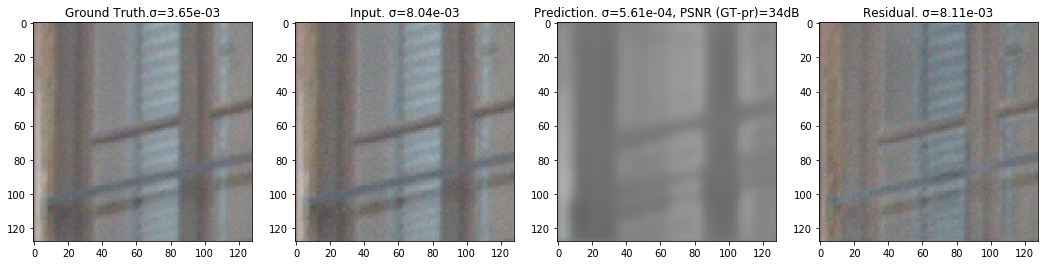

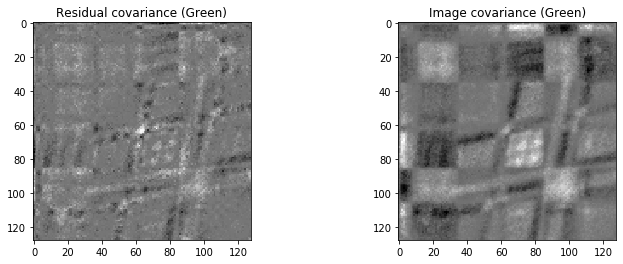

norm2(res_cov): 0.16241787374019623 	 norm2(im_cov): 0.748151421546936


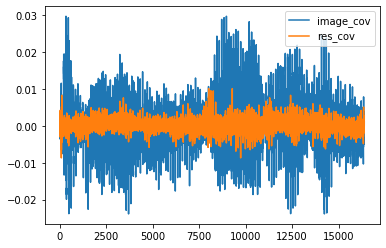

In [67]:
validate_images(model, val_im_ds, patch=7)